In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from preprocessing import preprocessing
from features_engineering import augment
from implementations import *
from proj1_helpers import *
import pickle as pkl
import yaml
from cross_validation import cross_validation_ridge
from features_engineering import augment

## Load the training data into feature matrix, class labels, and event ids:

In [61]:
with open("parameters.yaml") as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
COMBINED_DEGREES = params['COMBINED_DEGREES']
SIMPLE_DEGREES = params['SIMPLE_DEGREES']
TAN_HYP_DEGREES = params['TAN_HYP_DEGREES']
INVERSE_LOG_DEGREES = params['INVERSE_LOG_DEGREES']
ROOT_DEGREES = params['ROOT_DEGREES']
NUM_SETS = params['NUM_SETS']
DATA_TRAIN_PATH = params['DATA_TRAIN_PATH']
DATA_TEST_PATH = params['DATA_TEST_PATH']

In [5]:
y, tX_train, ids = load_csv_data(DATA_TRAIN_PATH)
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [62]:
(xs_train, masks_train) = preprocessing(tX_train)
(xs_test, masks_test) = preprocessing(tX_test)
xs_train_aug = []
xs_test_aug = []
for i in range(NUM_SETS):
    xs_train_aug.append(augment(xs_train[i], 
                          COMBINED_DEGREES[i], 
                          SIMPLE_DEGREES[i], 
                          TAN_HYP_DEGREES[i], 
                          INVERSE_LOG_DEGREES[i], 
                          ROOT_DEGREES[i]))
#     xs_test_aug.append(augment(xs_test[i], 
#                       COMBINED_DEGREES[i], 
#                       SIMPLE_DEGREES[i], 
#                       TAN_HYP_DEGREES[i], 
#                       INVERSE_LOG_DEGREES[i], 
#                       ROOT_DEGREES[i]))
# y=y[:,np.newaxis]
# y_logistic=(y+1)/2

Degree 2
Degree 3
Degree 2
Degree 3
Degree 2


In [24]:
# pred_len=tX_test.shape[0]
# lq=lambda a,b,c,d,e,f:least_squares(a,b)
# lqgd=lambda a,b,c,d,e,f: least_squares_GD(a, b, d, e, f)
# lqsgd=lambda a,b,c,d,e,f: least_squares_SGD(a, b, d, e, f)
# r=lambda a,b,c,d,e,f: ridge_regression(a, b, c)
# lgd=lambda a,b,c,d,e,f: logistic_regression_GD(a,b,d,e,f)
# lsgd=lambda a,b,c,d,e,f: logistic_regression_SGD(a,b,d,e,f)
# rlgd=reg_logistic_regression_GD
# rlsgd=reg_logistic_regression_SGD

In [65]:
lambdas = np.logspace(-15, -1, 5) 
full_accuracies = []
for i in range(NUM_SETS):
    print("Jet Num = {}".format(i))
    accuracies = []
    for l in lambdas:
        print(l)
        accuracies.append(np.mean(cross_validation_ridge(y[masks_train[i]], xs_train_aug[i], 5, l)))
    full_accuracies.append(accuracies)

Jet Num = 0
1e-15
3.1622776601683794e-12
1e-08
3.1622776601683795e-05


KeyboardInterrupt: 

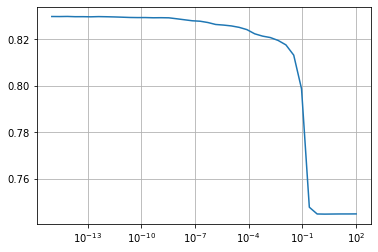

In [60]:
plt.subplot(3, 1, 1, sharex=True)
plt.plot(lambdas, full_accuracies[0], 'o-')

plt.subplot(3, 1, 2, sharex=True)
plt.plot(lambdas, full_accuracies[1], '.-')

plt.subplot(3,1,3, sharex=True)
plt.plot(lambdas, full_accuracies[2], '*-')

plt.xscale("log")

plt.show()

In [ ]:
# def cross_val(y,x,p,reg_f):
#     d=len(y)
#     rand_ind = np.random.permutation(d)
#     cut = int(p*d) # where to cut train/validation
#     x_train, y_train = x[rand_ind][:cut], y[rand_ind][:cut]
#     x_val, y_val = x[rand_ind][cut:], y[rand_ind][cut:]
    
#     (xs_train, masks_train) = preprocessing(x_train)
#     (xs_val, masks_val) = preprocessing(x_val)
#     ytrl=np.where(ytr==-1,0,1)
#     # Logistic Or Not
#     ys=[ytrl if logis else ytr for logis in logistics]
#     y_bar=predictions(ytr,ys, xstr, xste, mtr, mte, reg_fs, len(yte), degrees, lambdas, max_iters, gammas, logistics)
#     yte[yte==0]=-1
#     print(np.sum((yte==y_bar))/len(yte))

    
# basic_cross(y,tX_train,0.8,reg_fs)

## Generate predictions and save ouput in csv format for submission:

In [ ]:
# OUTPUT_PATH = '../predictions.csv' # TODO: fill in desired name of output file for submission
# # y_pred = predict_labels(weights, tX_test)
# create_csv_submission(ids_test, y_submission, OUTPUT_PATH)